In [1]:
import pandas as pd       
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import glob

import warnings
warnings.filterwarnings('ignore')

2021-12-20 20:59:50.734258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 20:59:50.734294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Config data
IMG_SIZE = 224
BATCH = 32

In [3]:
# Set path for images
train_normal = glob.glob("chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("chest_xray/test/PNEUMONIA/*")

In [4]:
# Build dataframe of dataset
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

<AxesSubplot:xlabel='class', ylabel='count'>

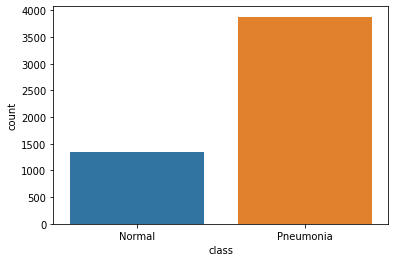

In [5]:
sns.countplot(data=df_train, x="class")

<AxesSubplot:xlabel='class', ylabel='count'>

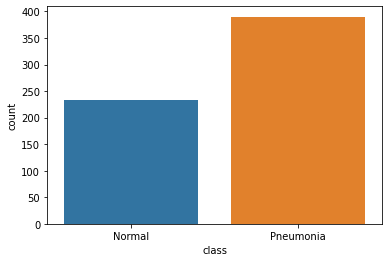

In [7]:
sns.countplot(data=df_test, x="class")

Number of Normal and Pneumonia datas are not skewed. Hence, accuracy score is a good validation criteria.

In [54]:
# Split images to training and validation use.
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 1, stratify = df_train['class'])

In [56]:
# Scale and generate more images for training for higher model accuracy.
train_datagen = ImageDataGenerator(# rescale=1/255.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1)

# Input images into image data generator
ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [57]:
# Load VGG16 for transfer learning & remove last layer
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

# Freeze training for VGG16 layers
base_model.trainable = False

# Build model
def get_pretrained():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))   
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  
    model = keras.Model(inputs=[inputs], outputs=output)
    return model

In [58]:
keras.backend.clear_session()

# Build model and set loss as binary_crossentropy
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [59]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

In [60]:
# Fit model
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 10,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/10
130/130 [==============================] - 331s 3s/step - loss: 1.1151 - binary_accuracy: 0.6609 - val_loss: 0.5058 - val_binary_accuracy: 0.7775 - lr: 5.0000e-05
Epoch 2/10
130/130 [==============================] - 328s 3s/step - loss: 0.4257 - binary_accuracy: 0.8358 - val_loss: 0.3355 - val_binary_accuracy: 0.8596 - lr: 5.0000e-05
Epoch 3/10
130/130 [==============================] - 327s 3s/step - loss: 0.3317 - binary_accuracy: 0.8808 - val_loss: 0.2830 - val_binary_accuracy: 0.8892 - lr: 5.0000e-05
Epoch 4/10
130/130 [==============================] - 329s 3s/step - loss: 0.2924 - binary_accuracy: 0.8879 - val_loss: 0.2531 - val_binary_accuracy: 0.9045 - lr: 5.0000e-05
Epoch 5/10
130/130 [==============================] - 327s 2s/step - loss: 0.2657 - binary_accuracy: 0.8961 - val_loss: 0.2619 - val_binary_accuracy: 0.8988 - lr: 5.0000e-05
Epoch 6/10
130/130 [==============================] - 323s 2s/step - loss: 0.2338 - binary_accuracy: 0.9099 - val_loss: 0.1948 - v

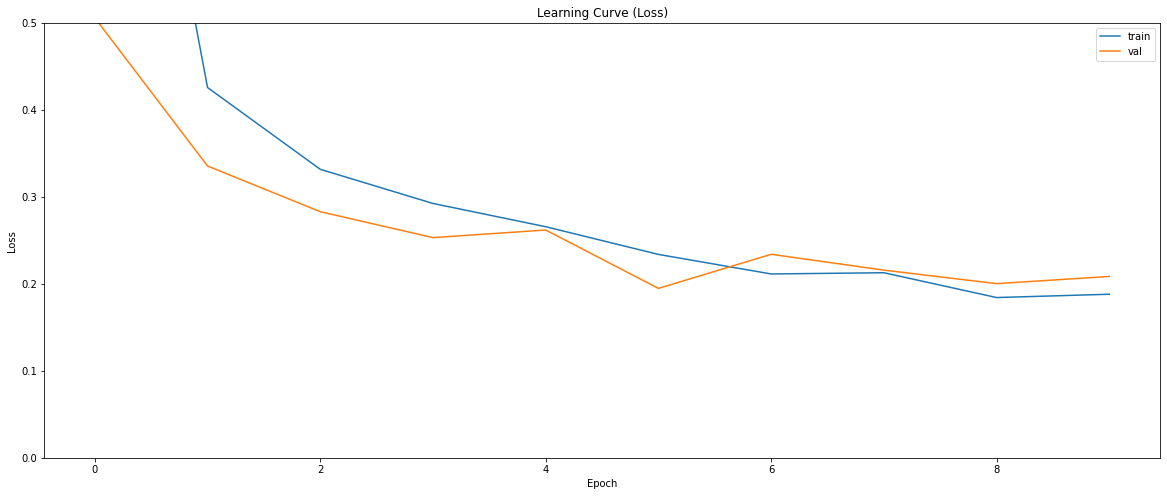

In [61]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [62]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.20850449800491333
Val accuracy: 0.9197707772254944


In [63]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2660299837589264
Test accuracy: 0.9006410241127014


In [64]:
# Save model
model_pretrained.save('Xray_model')

2021-12-20 23:38:00.820536: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Xray_model/assets


In [65]:
#Load model
new_model = tf.keras.models.load_model('Xray_model')

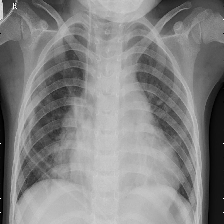

In [73]:
# Import X-ray image and display it
img_path = 'chest_xray/test/PNEUMONIA/BACTERIA-40699-0001.jpeg'
img = load_img(img_path,color_mode='rgb', target_size=(224, 224))
display(img)

In [74]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

In [75]:
x = preprocess_input(x)
# Predict image
features = new_model.predict(x)
features

array([[0.95328814]], dtype=float32)